# Lab 10: Model Design

## Table of Contents:
* [Model Validation](#zero-bullet)
* [Bias-Variance Tradeoff: Overfitting and Underfitting](#first-bullet)
* [Cross-Validation](#second-bullet)
* [Regularization](#third-bullet)
* [Hyperparameter Tuning](#fourth-bullet)

### Import Libraries

In [34]:
import sqlite3
import numpy as np
import scipy.io as io
from itertools import permutations
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, LeavePOut, validation_curve, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import make_pipeline
import pandas as pd
import seaborn as sns
import warnings
sns.set()
warnings.filterwarnings("ignore")

## 1. Model Validation <a class="anchor" id="zero-bullet"></a>

In [35]:
# Connect to SQLite database
conn = sqlite3.connect('digits.db')
cursor = conn.cursor()

# Execute a SELECT query to fetch all rows from the digits table
cursor.execute('SELECT * FROM digits')
rows = cursor.fetchall()

# Initialize lists to store the images and targets
X = []
Y = []

# Loop through the rows and convert the data back to its original format
for row in rows:
    # Convert the bytes back to a NumPy array
    image = np.frombuffer(row[1], dtype=np.float64)
    target = int(row[2])  # Explicitly cast target to integer

    # Append the image and target to the lists
    X.append(image)
    Y.append(target)

# X & Y are lists
# # Convert the lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# # Close the database connection
conn.close()

print("Shape of Features: ", X.shape) # print shape of features
print("Shape of Targets: ", Y.shape) # Print shape of ground truth

Shape of Features:  (1797, 64)
Shape of Targets:  (1797,)


In [32]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    """
    Utility Function to visualize the images
    """
    plt.figure(figsize=(12, 4)) # Initialize plt figure || 12 inches x 4 inches || 1 inch = 100 dots (pixels) by default | hence 1200 pixels x 400 pixels
    for i in range(data.shape[0]): # subsample size
        plt.subplot(1, data.shape[0], (i + 1)) # Subplot function is used to plot multiple figures in a plt figure. The first 2 args specifiy the shape of the figure matrix. And the final argument is the index/position where the sub plot be located.
        plt.imshow(data[i].reshape(shape), interpolation=interpolation)
        plt.title(labels[i])
        plt.xticks(()), plt.yticks(()) # empty xticks and yticks -> do not show gradations

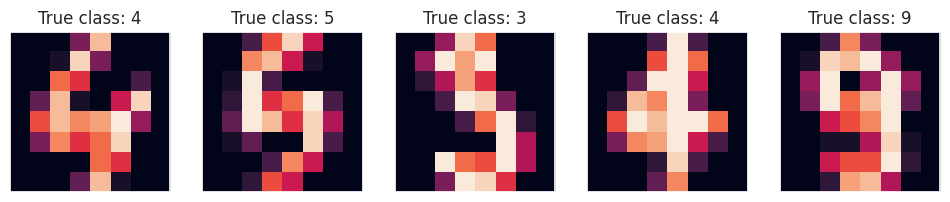

In [33]:
### Visualization of 5 random images
subsample = np.random.permutation(X.shape[0])[:5] # (1) X.shape[0] -> len(X) || (2) np.random.permutation(X.shape[0]) -> randomly permutes (shuffles) integers between (0,  X.shape[0])
images = X[subsample] #images.shape = (5, 64)
labels = ['True class: %d' % l for l in Y[subsample]]
plot_gallery(images, labels, shape=(8, 8))

Let's fit a K-neighbors classifier

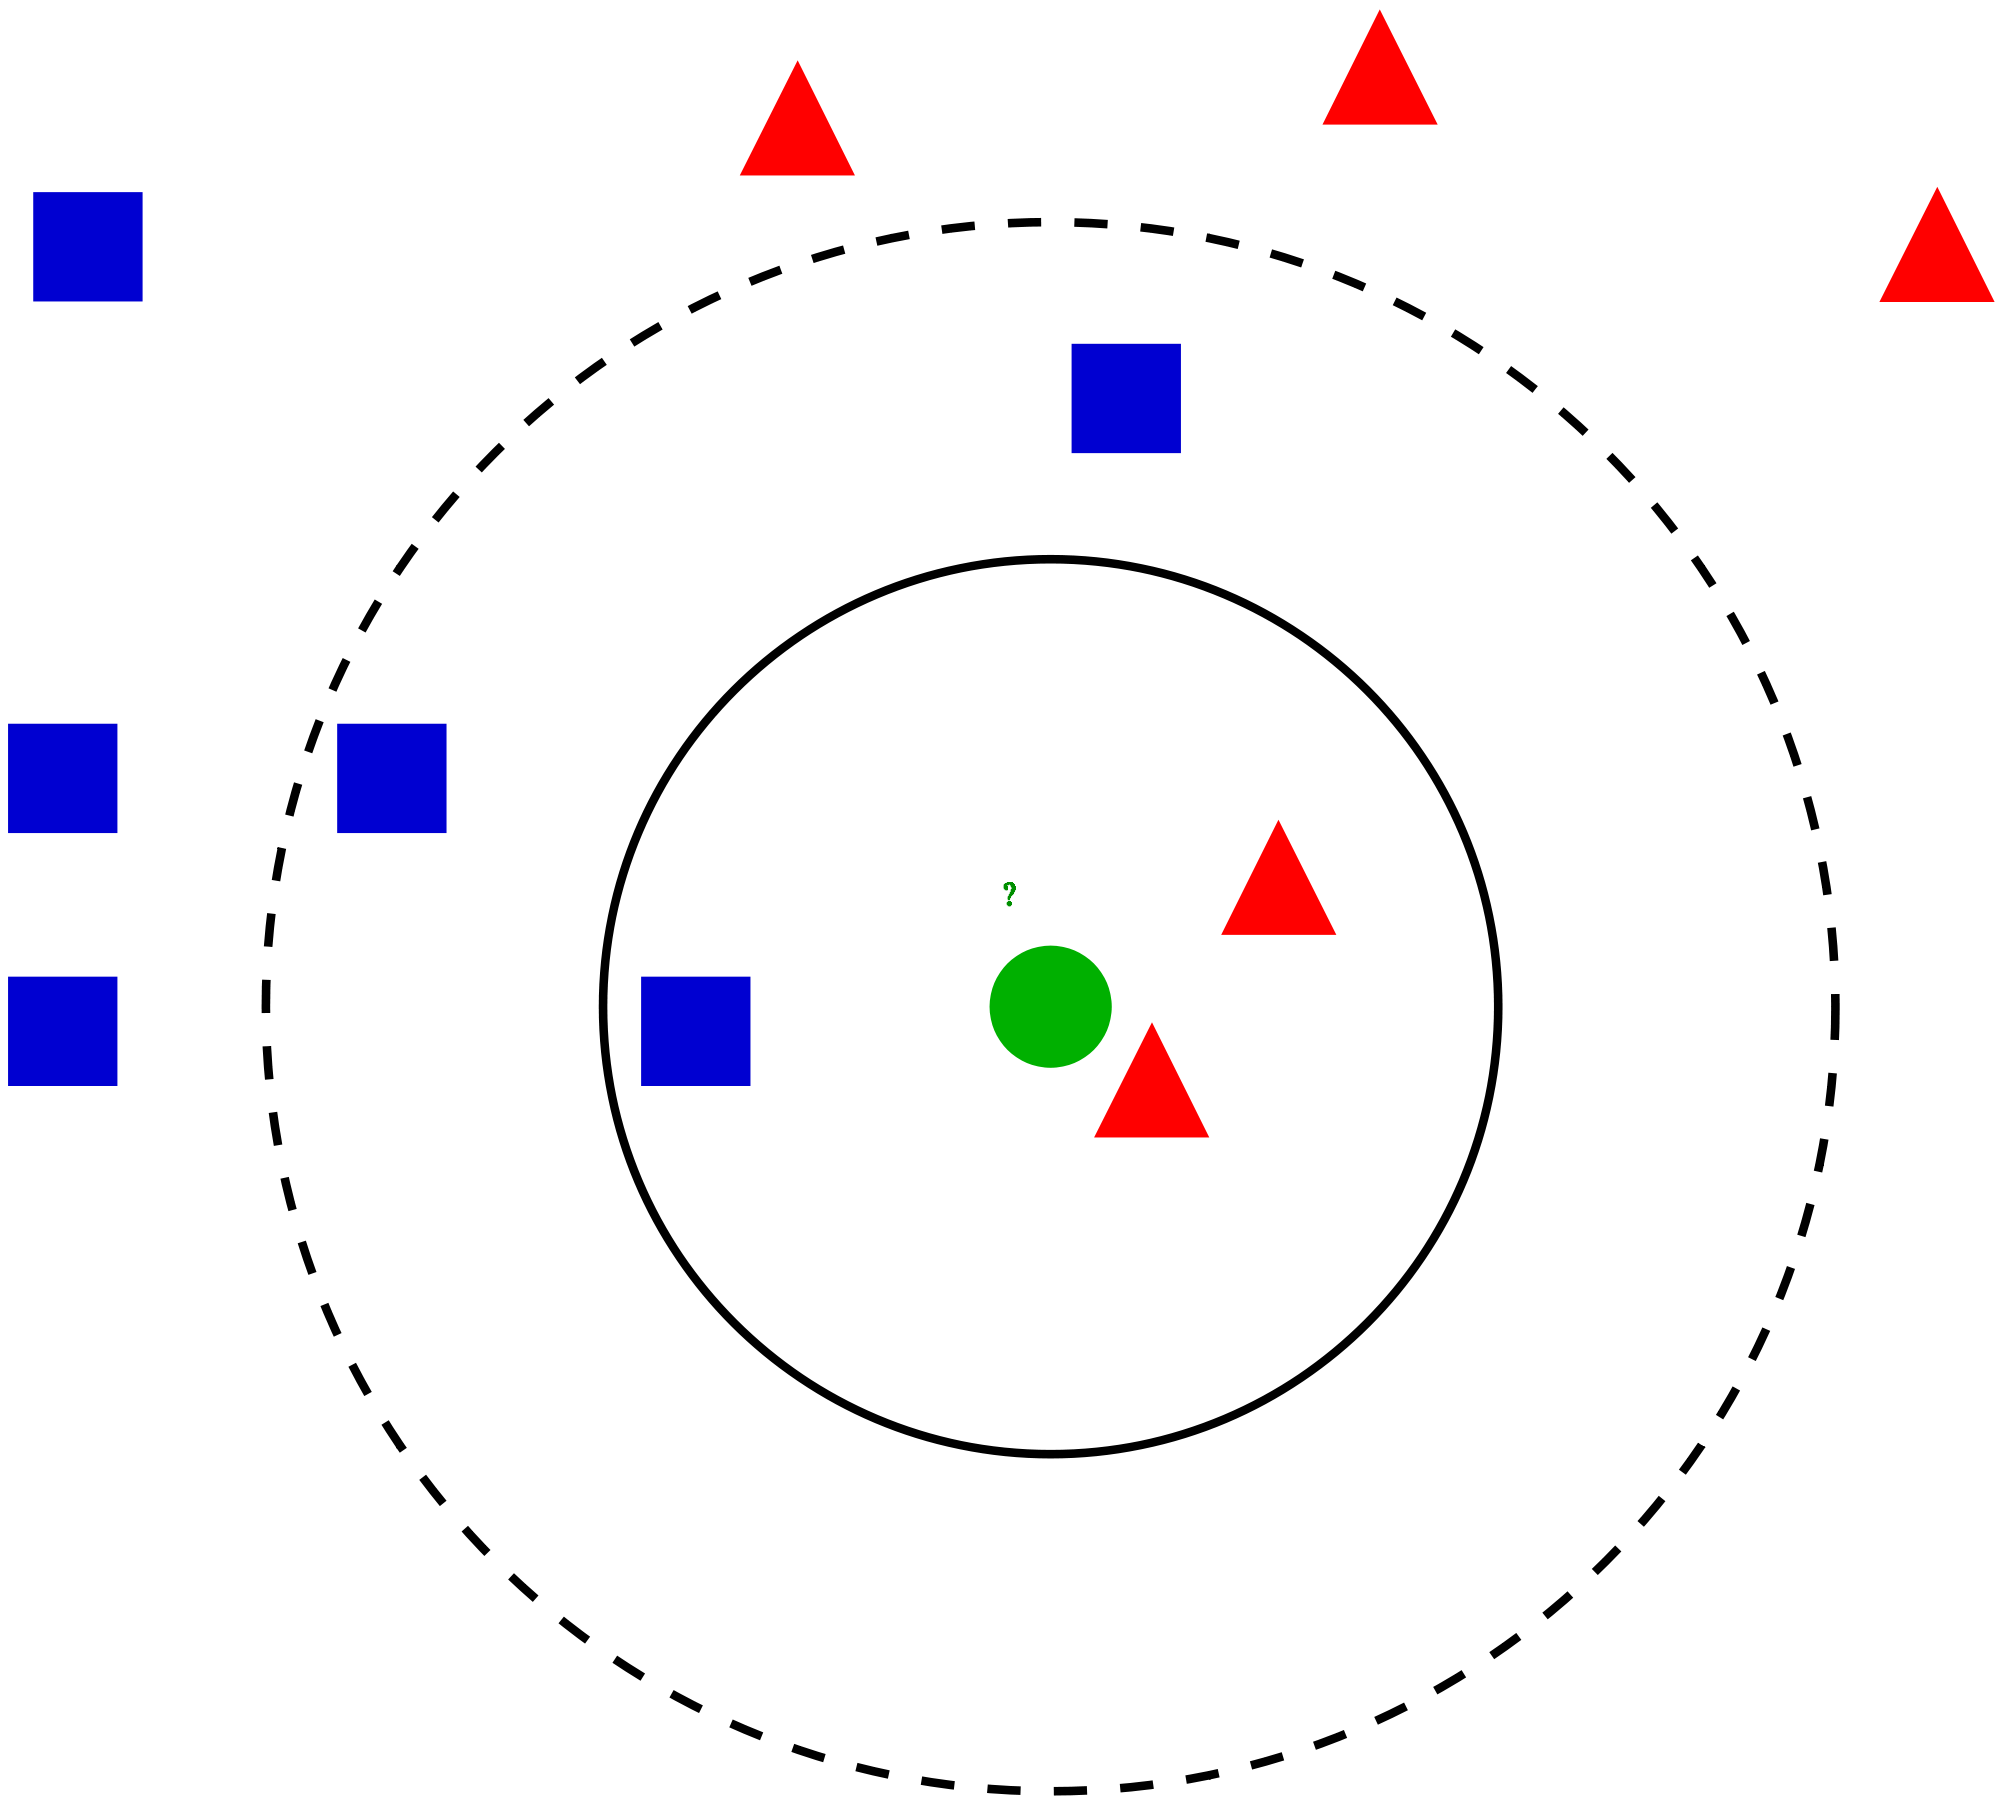

In [34]:
knn = KNeighborsClassifier(n_neighbors=1) # KNN Classfiers imported from sklearn. For inference, we will use the n=1 neighbors to determine the class || by default weights = "uniform" and hence independent of distance
knn.fit(X, Y)

KNeighborsClassifier(n_neighbors=1)

Now we'll use this classifier to *predict* labels for the data

In [35]:
y_pred = knn.predict(X)

Finally, we can check how well our prediction did:

In [36]:
print("{0} / {1} correct".format(np.sum(Y == y_pred), len(Y)))

1797 / 1797 correct


It seems we have a perfect classifier!

**Question:** What's wrong with assessing the performance of model on training set?

We will not get an unbiased estimate of the performance of our model

Above we made the mistake of testing our data on the same set of data that was used for training. **This is not a good idea**. If we optimize our estimator this way, we will tend to **over-fit** the data: that is, we learn the noisy patterns.

A better way to test a model is to use a hold-out set which doesn't enter the training

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8) # Divides data into train and test splits given the size of one of them || train_size = 0.8 is 80% of the data
X_train.shape, X_test.shape

((1437, 64), (360, 64))

In [38]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

357 / 360 correct


This gives us a more reliable estimate of how our model is doing.

## 2. Bias Variance Tradeoff: Overfitting and Underfitting <a class="anchor" id="first-bullet"></a>

**Setup:** We want to predict well on the dataset we have (Bias) and we also want to generalize well (change predictions when we encounter data we have not seen before). For the optimum model we will be at the sweet spot, which is why we are concerned with the bias variance tradeoff


![Bias-variance tradeoff](https://github.com/ethen8181/machine-learning/blob/master/regularization/images/bias_variance.png?raw=true)

**Note**: The x axis of this graph is model complexity

- **Bias:** The red line, measures how far off in general our models' predictions are from the correct value. Thus as our model gets more and more complex we will become more and more accurate about our predictions (Error steadily decreases).

- **Variance:** The cyan line, measures how different can our model be from one to another, as we're looking at different possible data sets. If the estimated model will vary dramatically from one data set to the other, then we will have very erratic predictions, because our prediction will be extremely sensitive to what data set we obtain. As the complexity of our model rises, variance becomes our primary concern.

#### Illustration of the Bias-Variance Tradeoff

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit

Question: When we are overfitting will our predictions have a higher variance or a lower variance?

In [5]:
"""
This piece of code defines a function test_func that takes two arguments: x and err.
The function calculates a value y based on x, and then potentially adds random noise to y based on the err parameter
"""
### Adding random noise in regression target
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err) # If satisfied, the new regression target will be sampled from a normal distribution wih mean as old target and std as err.
    return y

In [3]:
### Generating synthetic dataset based on number of points and error that is needed to be added
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1) # Set the random seed
    X = np.random.random(N) # Return random floats in [0.0, 1.0).
    y = test_func(X, error) # y = 10-1/(x+0.1)
    X = X[:, np.newaxis] #np.newaxis adds dimension. For e.g. (40, ) --> (40,1) | needed by model.train


    return X, y

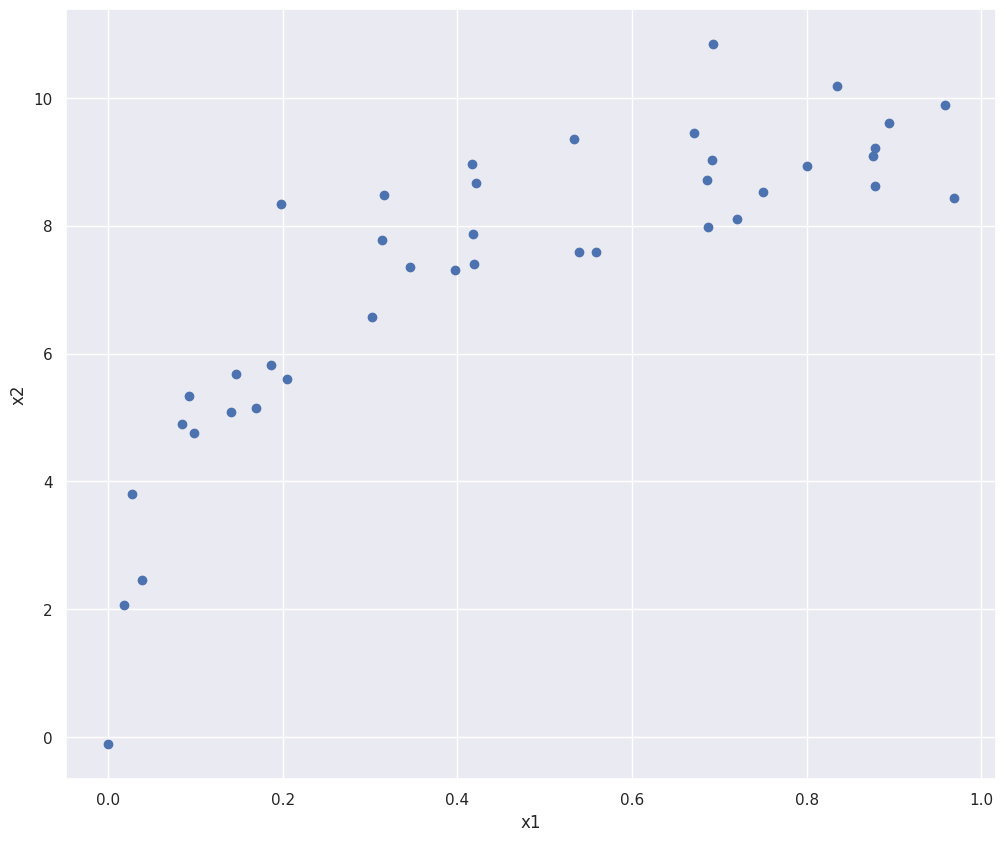

In [49]:
# Plotting the generated data
X, Y = make_data(40, error=1)
plt.figure(figsize=(12, 10))
plt.scatter(X.ravel(), Y) # Ravel function flattens the data i.e (40,1) --> (40,)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

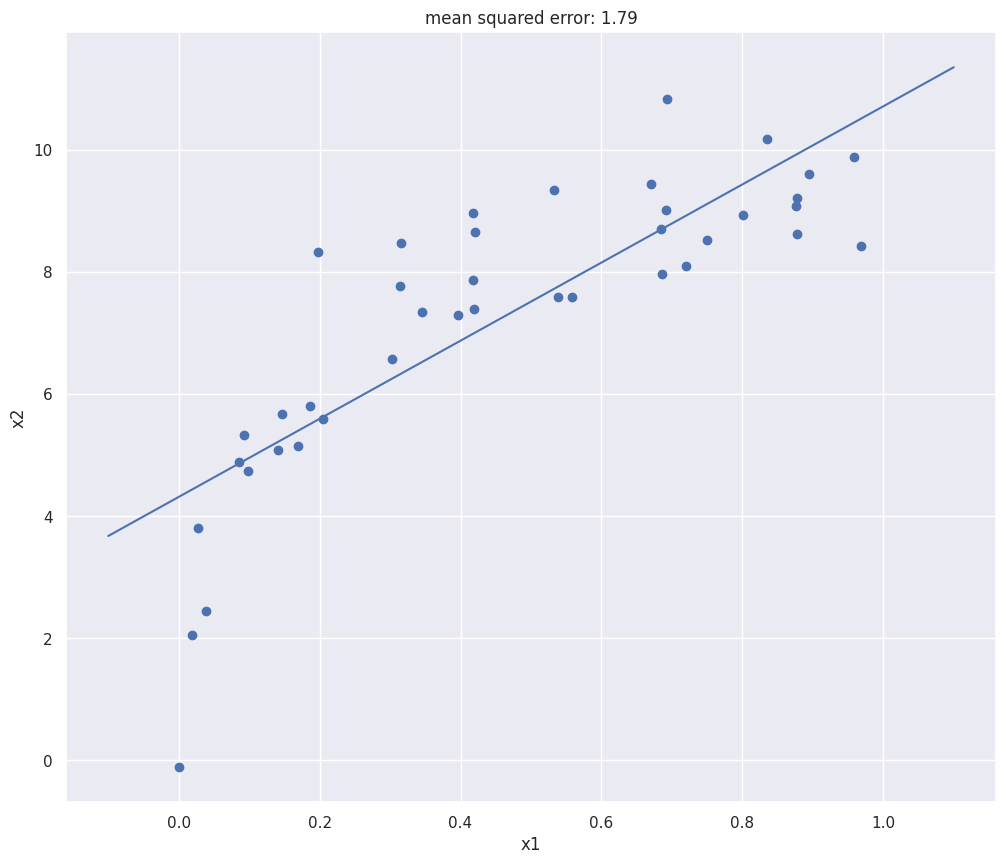

In [50]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None] # Initialze 500 equidistant test samples b/w [-0.1, 1.1] | for visualizing the graph
model = LinearRegression() # initialize the Linear Regression model
model.fit(X, Y) # Fit the model
y_test = model.predict(X_test) #

plt.figure(figsize=(12, 10))
plt.scatter(X.ravel(), Y) # X.ravel -> flattens X | (xdim, 1) -> (xdim, )
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), Y))) # calculating mse on the actual X
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

**Question**: If I say that a model is underfitting, what can I relatively say about it's bias?

High bias - then why would be want even a little bit of bias?




We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model is **biased**, or that it **under-fits** the data.

Let's try to improve this by creating a more complicated model.  We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs. Scikit-learn makes this easy with the ``PolynomialFeatures`` preprocessor, which can be pipelined with a linear regression.

Let's make a convenience routine to do this:

In [9]:
"""
PolynomialRegression function creates a pipeline that first transforms the input features into polynomial features of a specified degree,
and then applies linear regression to these transformed features

make_pipeline:
Transformers: These are objects that implement the fit and transform methods. Transformers are used to preprocess the data
Estimator: This is a machine learning model object that implements the fit method (and usually the predict method)
pipeline = make_pipeline(
    StandardScaler(),  # First transformer: standardize features
    PCA(n_components=2),  # Second transformer: apply PCA
    LogisticRegression()  # Estimator: logistic regression model
)

PolynomialFeatures(degree): if input is [a, b] and the degree is 2, the output features will be [1, a, b, a^2, ab, b^2]
"""
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

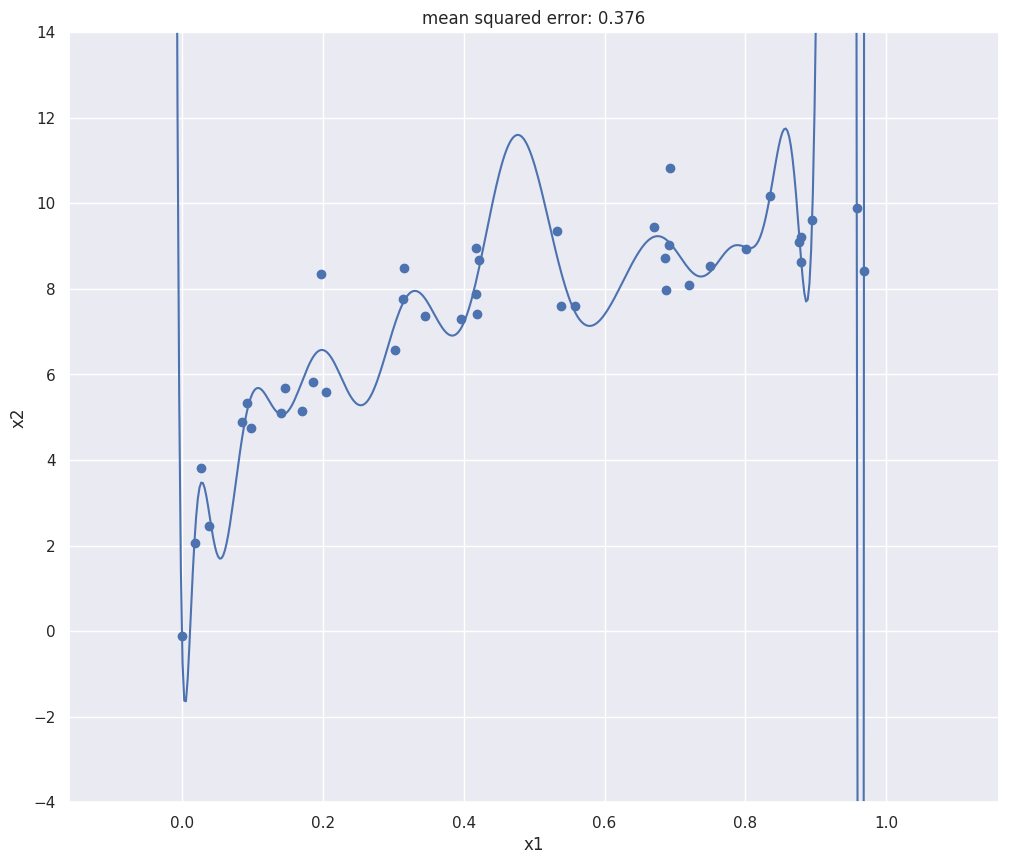

In [53]:
model = PolynomialRegression(30)
model.fit(X, Y)
y_test = model.predict(X_test)

plt.figure(figsize=(12, 10))
plt.scatter(X.ravel(), Y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), Y)))
plt.ylim(-4, 14)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

**Question**: If I say that a model is overfitting, what can I relatively say about it's bias and variance?

Low bias and high variance

Now we'll use this to fit a quadratic curve to the data.

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])


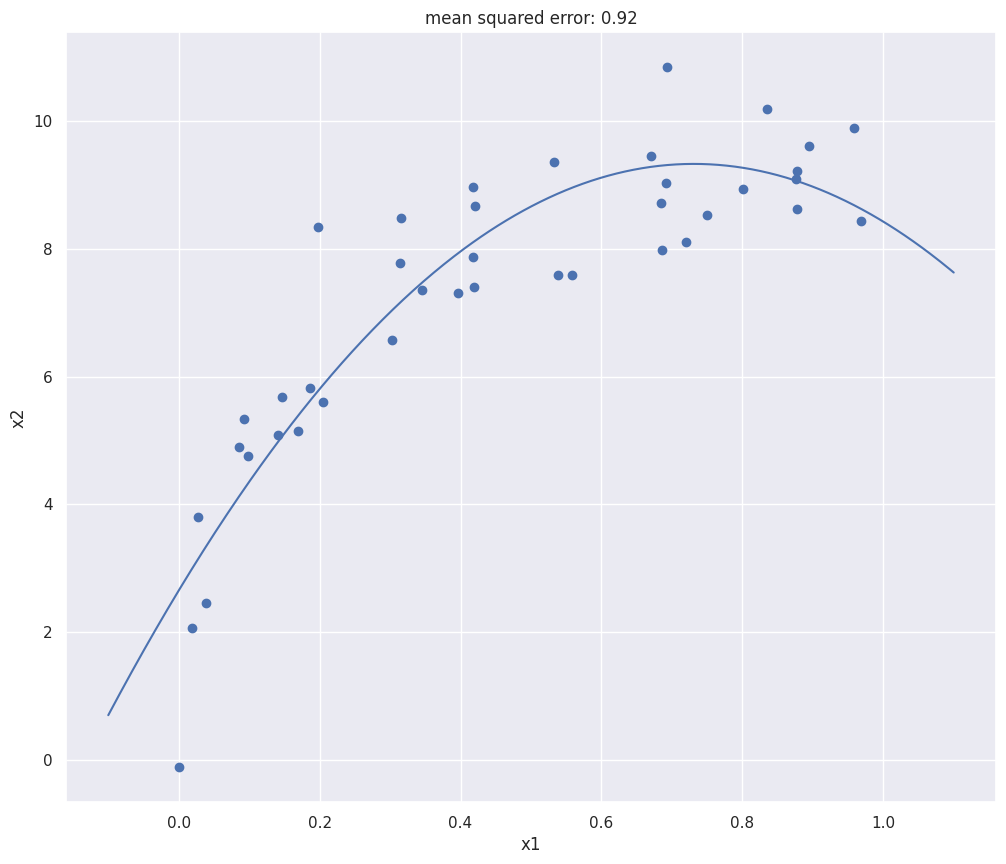

In [ ]:
model = PolynomialRegression(2)
print(model)
model.fit(X, Y)
y_test = model.predict(X_test)

plt.figure(figsize=(12, 10))
plt.scatter(X.ravel(), Y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), Y)))
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

Hence it is necessary to strike a balance between **Bias** and **Variance** where

**Bias** is the error on the training data and

**Variance** is the sensitivity of the model to the specific training data

(Specific training data) -> We have the test data as well

## 3. Cross-Validation <a class="anchor" id="third-bullet"></a>

Cross-validation provides a statistically more reliable estimation of the performance than a single training/test set split. It helps to effectively determine whether a model is suffering from underfitting/overfitting

K-Fold

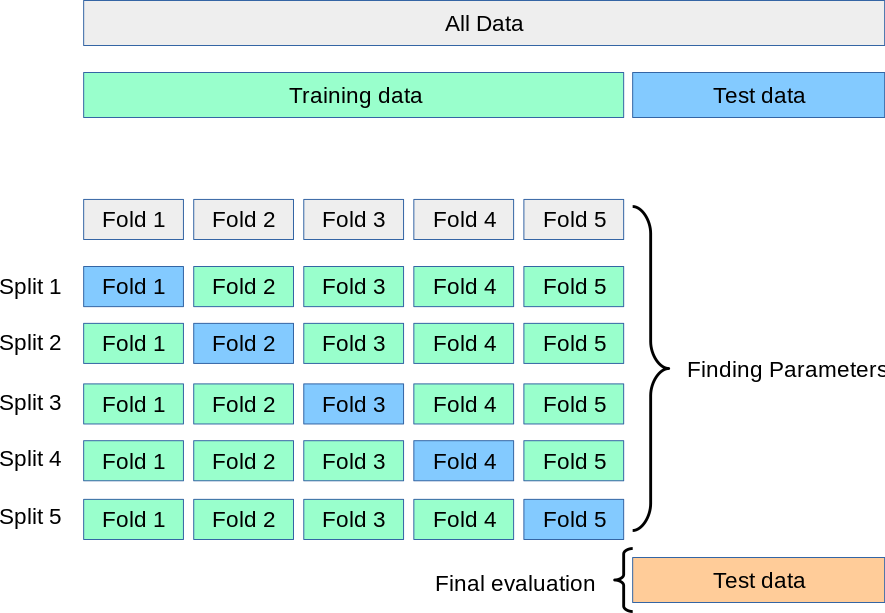

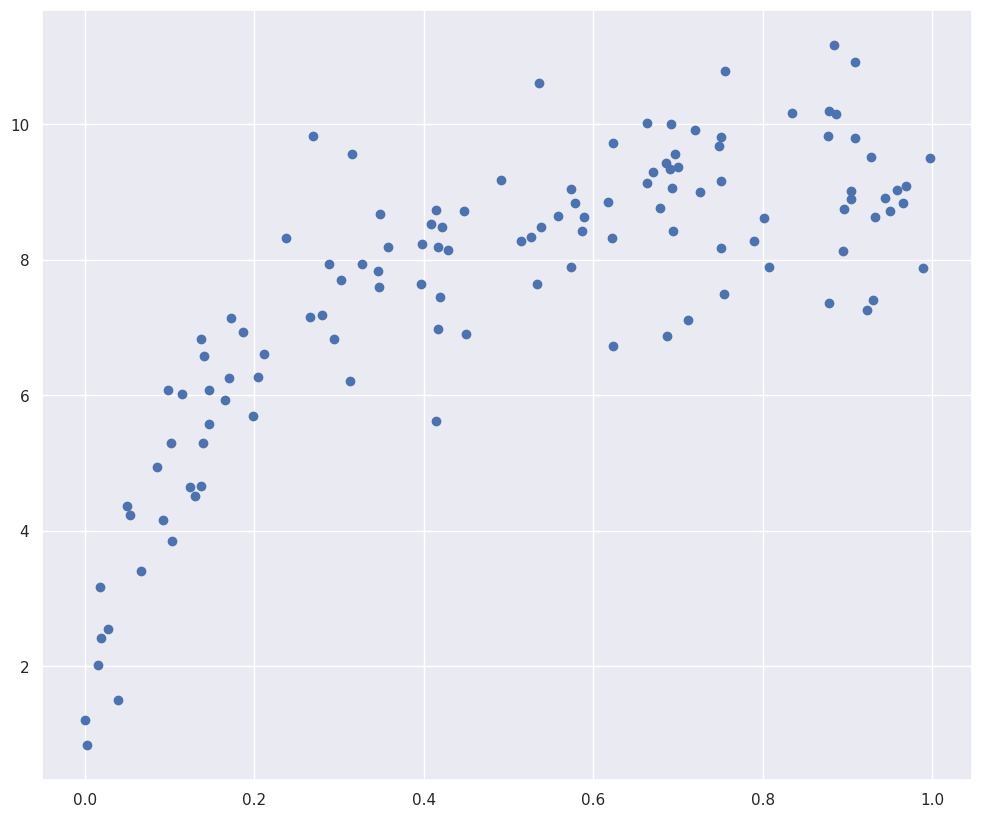

In [6]:
X, Y = make_data(120, error=1.0)
plt.figure(figsize=(12, 10))
plt.scatter(X, Y)
plt.show()

In [7]:
def rms_error(model, X, y):
    """
    Computes mean squared error. Our scoring metric for cross validation
    """
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

def plot_with_err(x, data, **kwargs):
    """
    Plots the scoring metric w.r.t. to varying hyperparameter. Highlights the area with 1 standard deviation.
    """
    mu, std = data.mean(1), data.std(1) # Mean and std taken across columns.
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2) # Function for plotting between two horizontal lines y1=mu-std and y2=mu+std

degree = np.arange(0, 18) # number of degrees in the polynomial

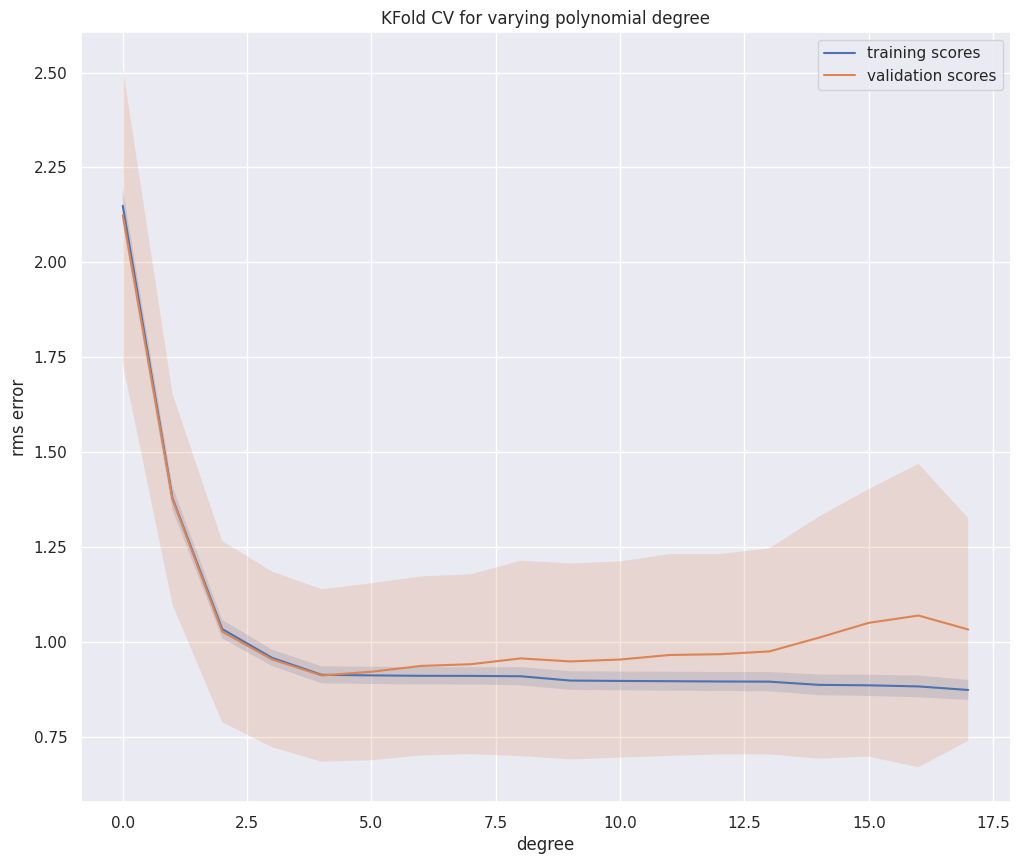

In [10]:
## K-Fold Cross Validation
kfold=KFold(n_splits=10)
train_scores, val_scores = validation_curve(PolynomialRegression(), X, Y, param_name='polynomialfeatures__degree', param_range=degree, cv=kfold, scoring=rms_error)
plt.figure(figsize=(12, 10))
plot_with_err(degree, train_scores, label='training scores')
plot_with_err(degree, val_scores, label='validation scores')
plt.title("KFold CV for varying polynomial degree")
plt.xlabel('degree')
plt.ylabel('rms error')
plt.legend()
plt.show()

Notice the trend here, which is common for this type of plot.

1. For a small model complexity, the training error and validation error are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.



#### Detecting Data Sufficiency with Learning Curves

As you might guess, the exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.  Here we'll illustrate the use of *learning curves*, which display this property.

The idea is to plot the mean-squared-error for the training and test set as a function of *Number of Training Points*

In [14]:
"""
Determines cross-validated training and test scores for different training set sizes.

A cross-validation generator splits the whole dataset k times in training and test data.
Subsets of the training set with varying sizes will be used to train the estimator
and a score for each training subset size and the test set will be computed.
Afterwards, the scores will be averaged over all k runs for each training subset size.
"""
def plot_learning_curve(degree=3):
    plt.figure(figsize=(12, 10))
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, Y, train_sizes=train_sizes, cv=kfold,
                                                  scoring=rms_error)
    # If we do 10 fold cross valiation and my training size is varied to 5 different values, what will be the shape of val_train and val_test?
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

Let's see what the learning curves look like for a linear model:

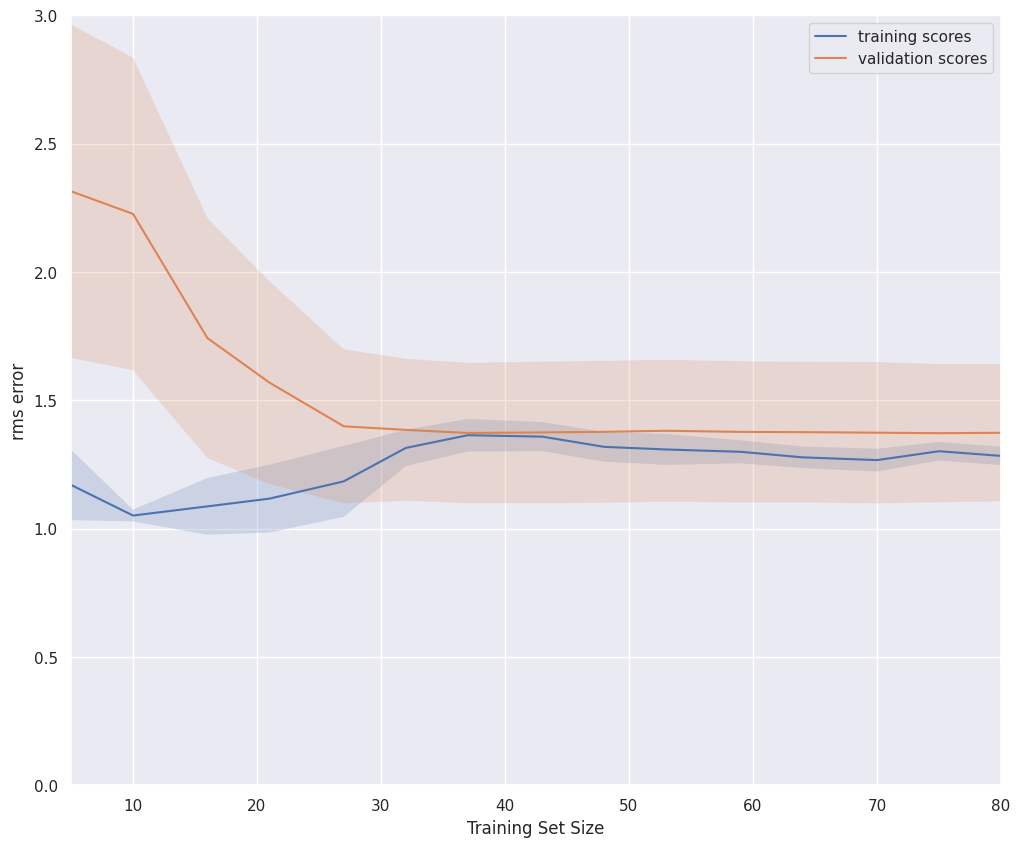

In [15]:
plot_learning_curve(1)

This shows a typical learning curve: for very few training points, there is a large separation between the training and test error, which indicates **over-fitting**.  Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential **under-fitting**.

As you add more data points, the training error will never increase, and the testing error will never decrease (why do you think this is?)

**Training Error**

The training error is likely to remain high or could even increase slightly. Since the model is too simple, it cannot fit the training data well, regardless of how much data is available.

**Testing Error**

The testing error is also likely to remain high. Adding more data won’t help because the model lacks the capacity or complexity to learn from the additional data.

It is easy to see that, in this plot, if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will *never* get you there.  For $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

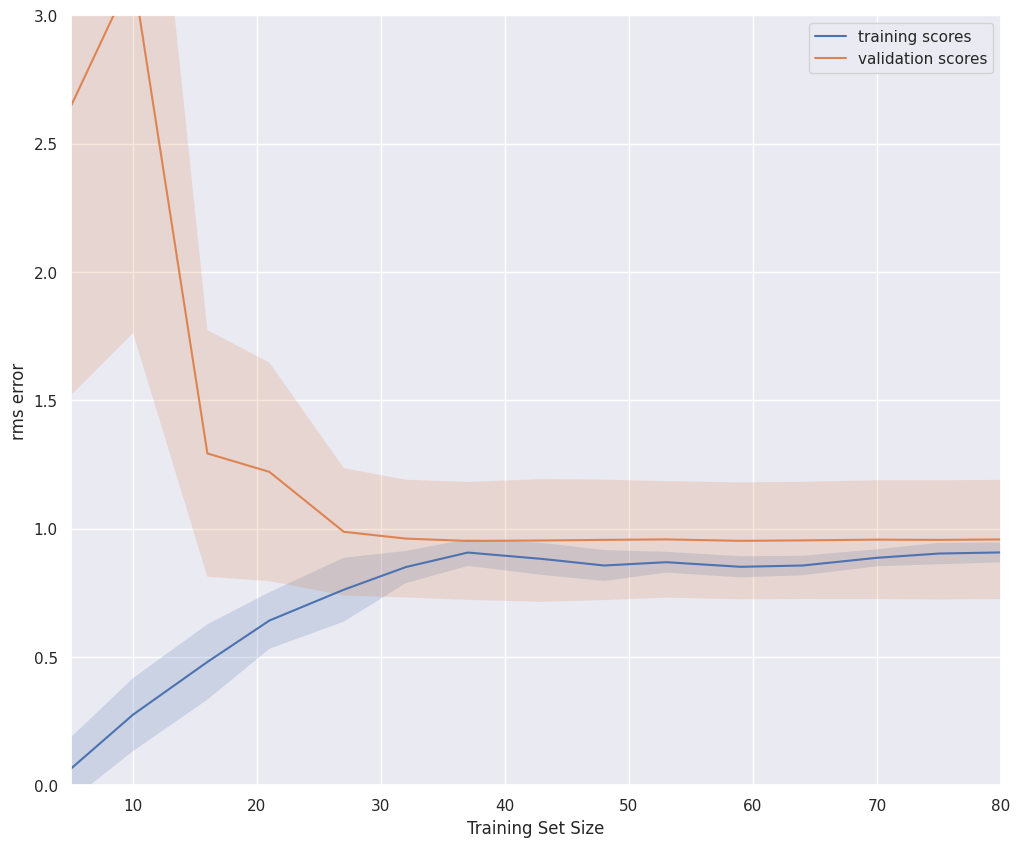

In [16]:
plot_learning_curve(3)

Here we see that by adding more model complexity, we've managed to lower the level of convergence to an rms error of 1.0!

What if we get even more complex?

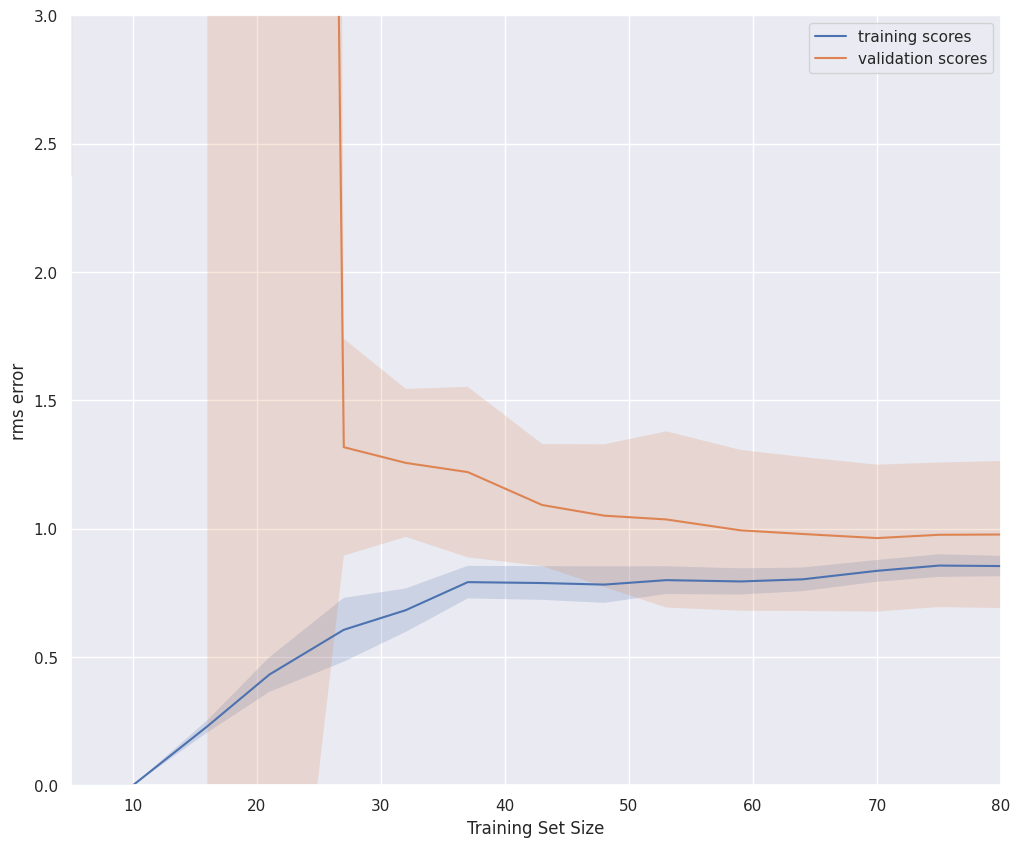

In [17]:
plot_learning_curve(10)

For an even more complex model, we still converge, but the convergence only happens for *large* amounts of training data.

So we see the following:

- you can **cause the lines to converge** by adding more points or by simplifying the model.
- you can **bring the convergence error down** only by increasing the complexity of the model.

Thus these curves can give you hints about how you might improve a sub-optimal model. If the curves are already close together, you need more model complexity. If the curves are far apart, you might also improve the model by adding more data.


#### Few points to remember:

We've gone over several useful tools for model validation

- The **Training Score** shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness
- The **Validation Score** shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used.
- **Validation Curves** are a plot of validation score and training score as a function of **model complexity**:
  + when the two curves are close, it indicates *underfitting*
  + when the two curves are separated, it indicates *overfitting*
  + the "sweet spot" is in the middle
- **Learning Curves** are a plot of the validation score and training score as a function of **Number of training samples**
  + when the curves are close, it indicates *underfitting*, and adding more data will not generally improve the estimator.
  + when the curves are far apart, it indicates *overfitting*, and adding more data may increase the effectiveness of the model.
  
These tools are powerful means of evaluating your model on your data.

## 4. Regularization <a class="anchor" id="fourth-bullet"></a>

When creating a model, our goal is to locate the optimum model complexity. If our model complexity exceeds this sweet spot, we are in effect overfitting our model; while if our complexity falls short of the sweet spot, we are underfitting the model. With all of that in mind, the notion of **regularization** is simply a useful technique to use when we think our model is too complex (models that have low bias, but high variance). It is a method for "constraining" or "regularizing" the **size of the coefficients** ("shrinking" them towards zero). The specific regularization techniques we'll be discussing are **Ridge Regression** , **Lasso Regression**, **ElasticNet*** e.t.c.

Recall that for a normal linear regression model of:

$$Y = \beta_0 + \beta_1X_1 + ... + \beta_pX_p$$

We would estimate its coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS). Or graphically, we're fitting the blue line to our data (the black points) that minimizes the sum of the distances between the points and the blue line (sum of the red lines) as shown below.

![Estimating coefficients](https://github.com/ethen8181/machine-learning/blob/master/regularization/images/estimating_coefficients.png?raw=true)

Mathematically, this can be denoted as:

$$RSS = \sum_{i=1}^n \left( y_i - ( \beta_0 + \sum_{j=1}^p \beta_jx_{ij} ) \right)^2$$

Where:

- $n$ is the **total number of observations (data)**.
- $y_i$ is the **actual output value of the observation (data)**.
- $p$ is the **total number of features**.
- $\beta_j$ is a **model's coefficient**.
- $x_{ij}$ is the **$i_{th}$ observation, $j_{th}$ feature's value**.
- $\beta_0 + \sum_{j=1}^p \beta_jx_{ij}$ is the **predicted output of each observation**.

Regularized linear regression models are very similar to least squares, except that the coefficients are estimated by minimizing a slightly different objective function. we **minimize the sum of RSS and a "penalty term"** that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes:

$$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes:

$$\text{RSS} + \alpha \sum_{j=1}^p \lvert \beta_j \rvert$$

**ElaticNet**  minimizes:
\begin{equation}
\text{RSS} + \alpha \sum_{j=1}^p \frac{1-\alpha}{2}\beta_j^2 + \alpha|\beta_j|
\end{equation}
Where $\alpha$ is a **tuning parameter** that seeks to balance between the fit of the model to the data and the magnitude of the model's coefficients:

- A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression.
- Increasing $\alpha$ penalizes the coefficients and thus shrinks them towards zero.

Thus you can think of it as, we're balancing two things to measure the model's total quality.

**Question**: Which of these regularization methods can be used for variable selection?

Lasso and ElasticNet

In [20]:
## Let's see the case of Polynomial regression which was overfitting
def PolynomialLassoRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         Lasso(**kwargs))

def PolynomialRidgeRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         Ridge(**kwargs))

def PolynomialElasticRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         ElasticNet(**kwargs))

In [21]:
"""
Designed to visualize how the weights (coefficients) of a model change as the regularization parameter (alpha) changes
"""

def weight_versus_alpha_plot(weight, alphas, features):
    """
    Pass in the estimated weight, the alpha value and the names
    for the features and plot the model's estimated coefficient weight
    for different alpha values
    """
    fig = plt.figure(figsize = (8, 6))

    # ensure that the weight is an array
    weight = np.array(weight)
    for col in range(weight.shape[1]):
        plt.plot(alphas, weight[:, col], label = features[col])

    plt.axhline(0, color = 'black', linestyle = '--', linewidth = 3)

    # manually specify the coordinate of the legend
    plt.legend(bbox_to_anchor = (1.3, 0.9))
    plt.title('Coefficient Weight as Alpha Grows')
    plt.ylabel('Coefficient weight')
    plt.xlabel('alpha')
    return fig

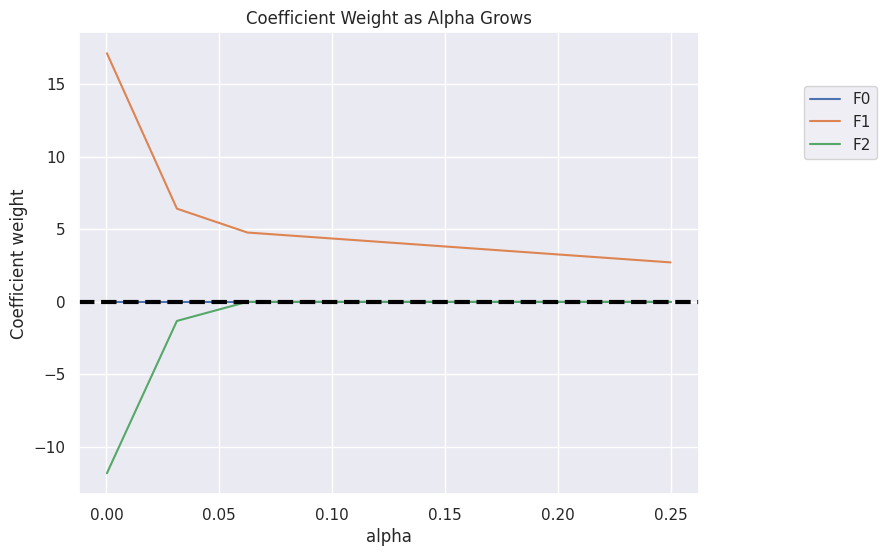

In [22]:
alphas=[2.0**c for c in np.arange(-12, -1)]
lasso_weight = []
for alpha in alphas:
    lasso = PolynomialLassoRegression(2, alpha = alpha) # Creates 3 output features per input feature c, x, x^2
    lasso.fit(X, Y)
    lasso_weight.append(lasso[1].coef_)
lasso_fig = weight_versus_alpha_plot(lasso_weight, alphas, ["F"+str(i) for i in range(3)])

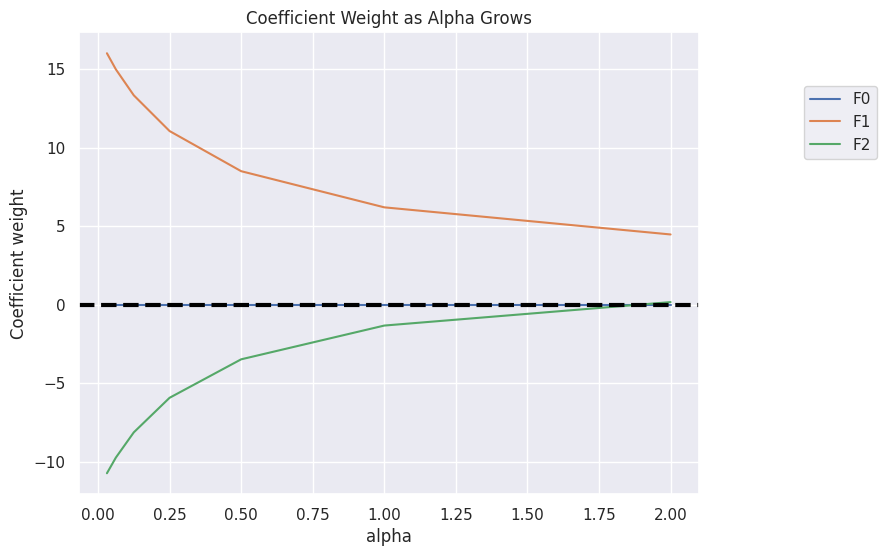

In [27]:
alphas=[2.0**c for c in np.arange(-5, 2)]
ridge_weight = []
for alpha in alphas:
    ridge = PolynomialRidgeRegression(2, alpha = alpha)
    ridge.fit(X, Y)
    ridge_weight.append(ridge[1].coef_)
ridge_fig = weight_versus_alpha_plot(ridge_weight, alphas, ["F"+str(i) for i in range(3)])

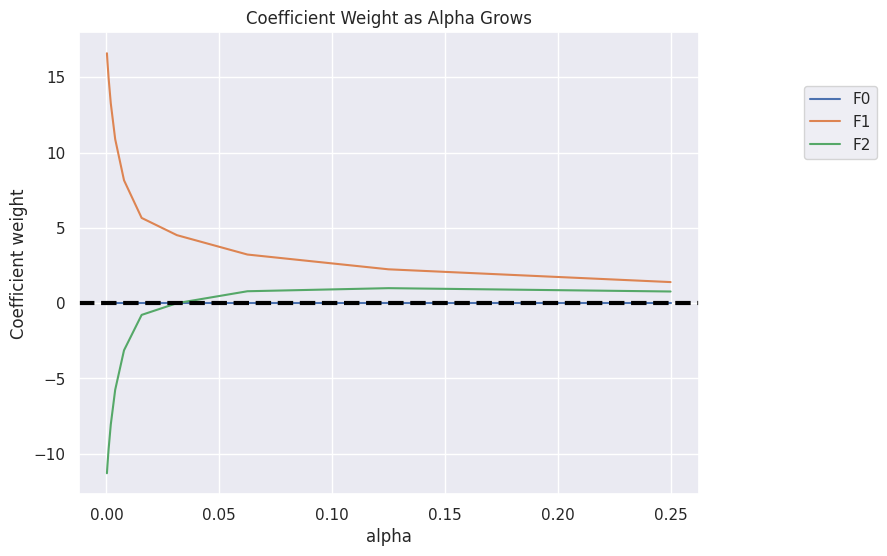

In [29]:
alphas=[2.0**c for c in np.arange(-12, -1)]
elastic_weight = []
for alpha in alphas:
    elasticnet = PolynomialElasticRegression(2, alpha = alpha)
    elasticnet.fit(X, Y)
    elastic_weight.append(elasticnet[1].coef_)
elastic_fig = weight_versus_alpha_plot(elastic_weight, alphas, ["F"+str(i) for i in range(3)])

## 5. Hyperparameter Tuning <a class="anchor" id="fifth-bullet"></a>

Hyperparameters cannot be learned by the model but instead need to be specified by the user before training the models. Here, we will find the best hyperparameters for random forest classifier using:
- Grid Search
- Random Search

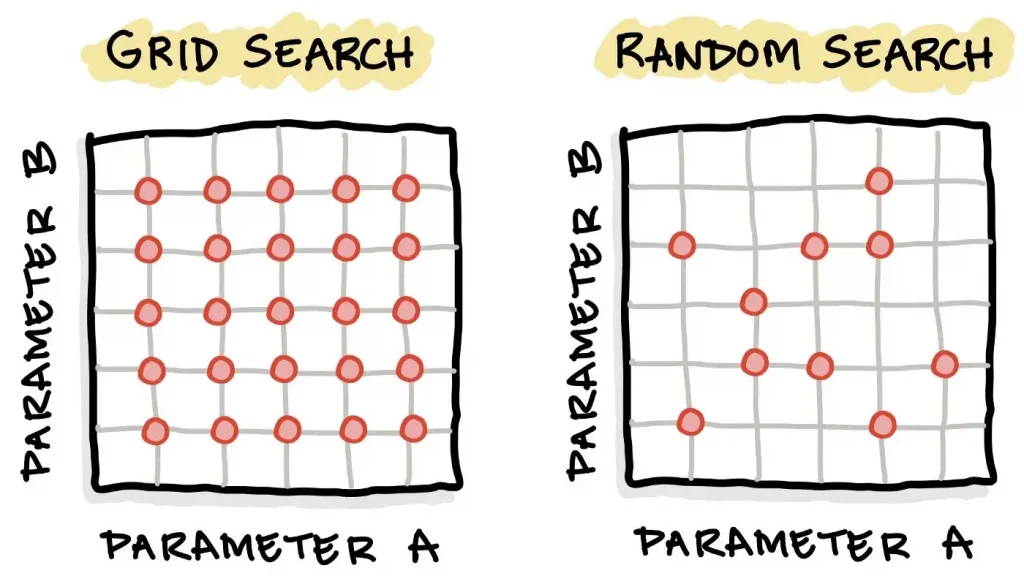

Only Grid Search

In [80]:
# Let's grid search for Random Forest  Classfier for Digit classification Task

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 20, num = 3)]

# Number of features to consider at every split
max_features = [round(x,2) for x in np.linspace(start = 0.3, stop = 1.0, num = 3)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 300, stop = 600, num = 3)]

# Method of selecting training subset for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Number of operations = 3x3x3x2 = 54

In [81]:
random_forest=RandomForestClassifier()
rf_grid = GridSearchCV(estimator = random_forest, param_grid = param_grid, scoring="accuracy")

In [82]:
rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [0.3, 0.65, 1.0],
                         'min_samples_leaf': [300, 450, 600],
                         'n_estimators': [10, 15, 20]},
             scoring='accuracy')

In [83]:
print("The best parameters of Grid Search are as follows: {} with a score of {}".format(rf_grid.best_params_, np.round(rf_grid.best_score_, 3)))

The best parameters of Grid Search are as follows: {'bootstrap': False, 'max_features': 0.3, 'min_samples_leaf': 300, 'n_estimators': 20} with a score of 0.683


First Random Search and then Grid Search

In [85]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]

# Number of features to consider at every split
max_features = [round(x,2) for x in np.linspace(start = 0.1, stop = 1.0, num = 10)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 100, stop = 600, num = 20)]

# Method of selecting training subset for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

In [88]:
rf_random = RandomizedSearchCV(estimator = random_forest,
                               param_distributions = param_grid,
                               n_iter = 50,
                               random_state= 42,
                               scoring="accuracy"
                               )

Number of Operations = 50

In [89]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': [0.1, 0.2, 0.3, 0.4,
                                                         0.5, 0.6, 0.7, 0.8,
                                                         0.9, 1.0],
                                        'min_samples_leaf': [100, 126, 152, 178,
                                                             205, 231, 257, 284,
                                                             310, 336, 363, 389,
                                                             415, 442, 468, 494,
                                                             521, 547, 573,
                                                             600],
                                        'n_estimators': [1, 12, 23, 34, 45, 56,
                                                         67, 78, 89, 100]},
                   random_state=42, scoring='accuracy')

In [67]:
print("The best parameters of Random Search are as follows: {} with a score of {}".format(rf_random.best_params_, np.round(rf_random.best_score_, 3)))

The best parameters of Random Search are as follows: {'n_estimators': 20, 'min_samples_leaf': 333, 'max_features': 0.3, 'bootstrap': True} with a score of 0.587


Let's analyze these results

In [90]:
results = rf_random.cv_results_
results_df = pd.DataFrame(results).sort_values(by='rank_test_score')
# results_df[["param_n_estimators",	"param_min_samples_leaf",	"param_max_features",	"param_bootstrap", "mean_test_score", "std_test_score"]]

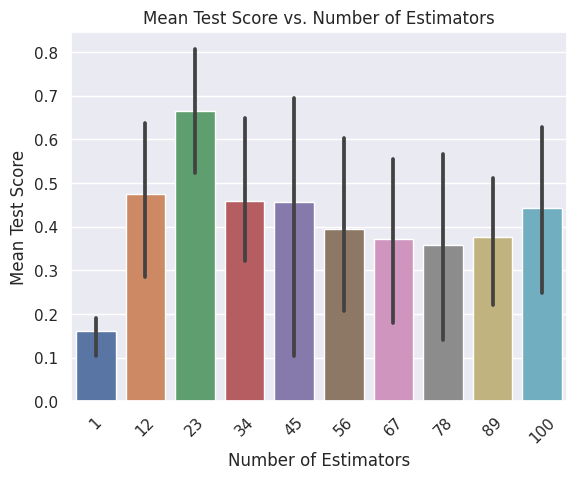

In [93]:
sns.barplot(data=results_df, x='param_n_estimators', y='mean_test_score')
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.title('Mean Test Score vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

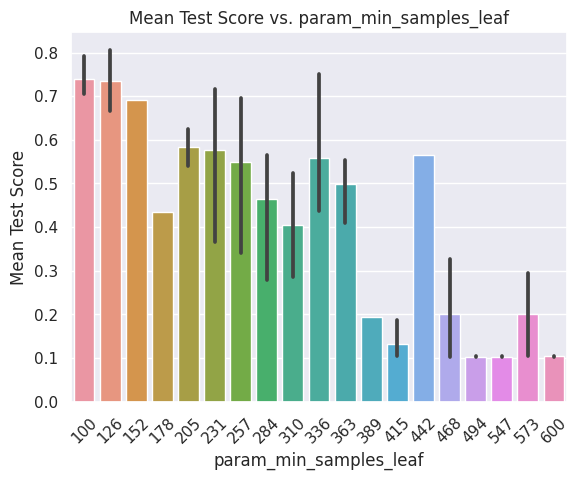

In [96]:
sns.barplot(data=results_df, x='param_min_samples_leaf', y='mean_test_score')
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.title('Mean Test Score vs. param_min_samples_leaf')
plt.xlabel('param_min_samples_leaf')
plt.ylabel('Mean Test Score')
plt.show()

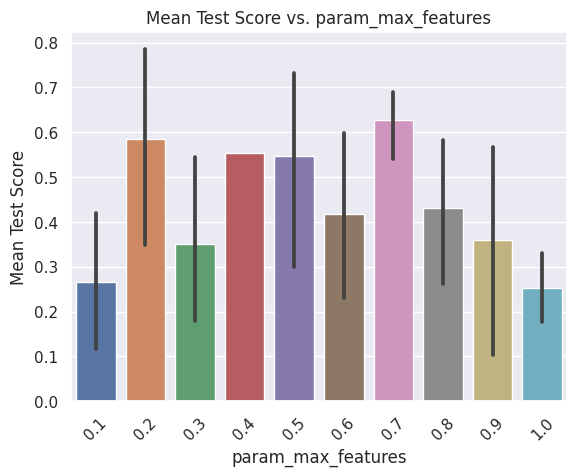

In [95]:
sns.barplot(data=results_df, x='param_max_features', y='mean_test_score')
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.title('Mean Test Score vs. param_max_features')
plt.xlabel('param_max_features')
plt.ylabel('Mean Test Score')
plt.show()

Random Search followed by Grid Search

In [97]:
# Let's grid search for Random Forest  Classfier for Digit classification Task

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 25, num = 3)]

# Number of features to consider at every split
max_features = [round(x,2) for x in np.linspace(start = 0.1, stop = 1.0, num = 10)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 100, stop = 150, num = 3)]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf}

In [98]:
random_forest=RandomForestClassifier()
rf_grid = GridSearchCV(estimator = random_forest, param_grid = param_grid, scoring="accuracy")

In [99]:
rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9, 1.0],
                         'min_samples_leaf': [100, 125, 150],
                         'n_estimators': [10, 17, 25]},
             scoring='accuracy')

In [100]:
print("The best parameters of Grid Search are as follows: {} with a score of {}".format(rf_grid.best_params_, np.round(rf_grid.best_score_, 3)))

The best parameters of Grid Search are as follows: {'max_features': 0.1, 'min_samples_leaf': 100, 'n_estimators': 25} with a score of 0.824
